# Proactive Interference Branch


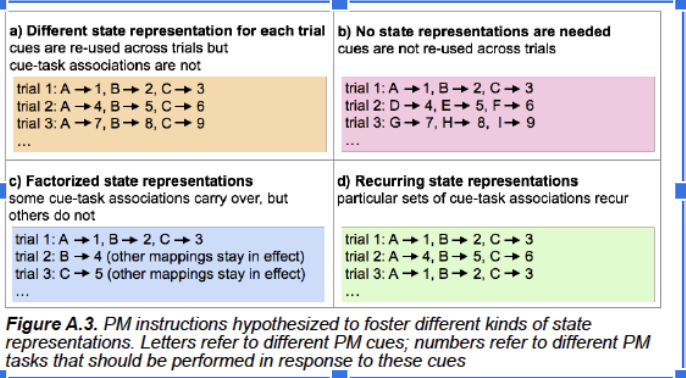

In [1]:
from glob import glob as glob
from itertools import product

import torch as tr
import numpy as np

from PM_models import *
from PM_tasks import *

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

# TODO
- laptop train no randomization
- run ntokens=5,seqlen=3
- run EM0


# train and eval
- no randomization (single emat)

In [66]:
maxsoftmax = lambda ulog: tr.argmax(tr.softmax(ulog,-1),-1)

def train_model(net,task,neps,ntrials,seqlen,switchmaps):
  """ 
  variable sequence length training
  closed loop randomizing of embedding
  """
  lossop = tr.nn.CrossEntropyLoss()
  optiop = tr.optim.Adam(net.parameters(), lr=0.001)
  acc = -np.ones(neps)
  for ep in range(neps):
    # shuffle emat every epoch
    task.shuffle_emat()
    # forward prop
    tseq,xseq,ytarget = task.gen_ep_data(ntrials,seqlen=seqlen,switchmaps=switchmaps)
    yhat_ulog = net(tseq,xseq)
    # eval
    trial_acc = np.mean((maxsoftmax(yhat_ulog) == ytarget).numpy())
    acc[ep] = trial_acc
    # backprop
    for tstep in range(len(tseq)):
      optiop.zero_grad()
      loss = lossop(yhat_ulog[tstep],ytarget[tstep])
      loss.backward(retain_graph=True)
      optiop.step()
  return acc

def eval_model(net,task,neps,ntrials,seqlen,switchmaps):
  """ 
  fixed sequence length eval
  new embedding for every episode
  """
  score = -np.ones((neps,ntrials*(seqlen+task.ntokens)))
  for ep in range(neps):
    task.shuffle_emat()
    tseq,xseq,ytarget = task.gen_ep_data(ntrials,seqlen,switchmaps)
    yhat_ulog = net(tseq,xseq)
    score[ep] = (maxsoftmax(yhat_ulog) == ytarget).squeeze()
  return score

In [78]:
seed = np.random.randint(999)
stsize = 25
sdim = 10
ntokens = 3

task = PurePM(
        ntokens=ntokens,
        stimdim=sdim,
        seed=seed
)

net = PINet(
        stimdim=sdim,
        stsize=stsize,
        outdim=ntokens,
        ninstructs=ntokens+1,
        seed=seed
)
net.EMBool = True

In [ ]:
tr_neps = 10000
ntrials = 2
seqlen = 5
tr_switch = 1
tr_acc = train_model(net,task,tr_neps,ntrials,seqlen,tr_switch)


In [ ]:
plt.plot(tr_acc)

In [ ]:
ev_neps = 500
ev_ntrials = 5
ev_seqlen = 15
ev_switch = 1
cL=['purple','b']
for em in [0,1]:
  net.EMbool = em
  acc = eval_model(net,task,ev_neps,ev_ntrials,ev_seqlen,ev_switch).mean(0)
  plt.plot(acc,c=cL[em])
  plt.scatter(range(len(acc)),acc,c=cL[em])
  
plt.axhline(1/ntokens,c='r',ls='--')
plt.ylim(0,1.05)

# cluster data
- model with LSTM perceptual layer

### load net

In [30]:
def load_net(seed,trep,switchmaps,ntokens):
  seqlen = ntokens
  ## model names
#   model_name = 'LSTM_25'
  model_name = 'LSTM_25-EM_conjcode'
  ##
  trep *= 100000
  fpath = 'model_data/PITask/'
  fpath += "%s-ntokens_%i-seqlen_%i-ntrials_2-switchmaps_%s-seed_%s-tr_%s-model.pt"%(
              model_name,ntokens,seqlen,switchmaps,seed,trep)
  net = PINet(
          stimdim=10,
          stsize=25,
          outdim=ntokens,
          ninstructs=ntokens+1,
          seed=seed
  )
  # load
  net.load_state_dict(tr.load(fpath))
  return net


def load_netL(EM,trep,switch,ntokens=3):
  netL = []
  for sd in range(20):
    try:
      net = load_net(sd,trep,switch,ntokens)
      net.EMbool = EM
      netL.append(net)
    except:
      pass
  print('N =',len(netL),'loaded nets')
  return netL


def eval_net(net,task,neps,ntrials,seqlen,switchmaps):
  """ 
  fixed sequence length eval
  new embedding for every episode
  returns score
  """
  maxsoftmax = lambda ulog: tr.argmax(tr.softmax(ulog,-1),-1)
  score = -np.ones((neps,ntrials*(seqlen+task.ntokens)))
  for ep in range(neps):
    task.randomize_emat()
    tseq,xseq,ytarget = task.gen_ep_data(ntrials,seqlen,switchmaps)
    yhat_ulog = net(tseq,xseq)
    score[ep] = (maxsoftmax(yhat_ulog) == ytarget).squeeze()
  return score

def eval_netL(netL,task,neps,ntrials,seqlen,switchmaps):
  """ returns acc `[sub,tsteps]`
  """
  nsubs = len(netL)
  tsteps = ntrials*(seqlen + task.ntokens)
  group_acc = np.ones([nsubs,tsteps]) 
  for sid,net in enumerate(netL):
    evsc = eval_net(net,task,neps,ntrials,seqlen,switchmaps)
    group_acc[sid] = evsc.mean(0)
  return group_acc
  


### model: no EM

### model: percept FF layer, conjunctive (FF+main_cell) EM keys

N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets


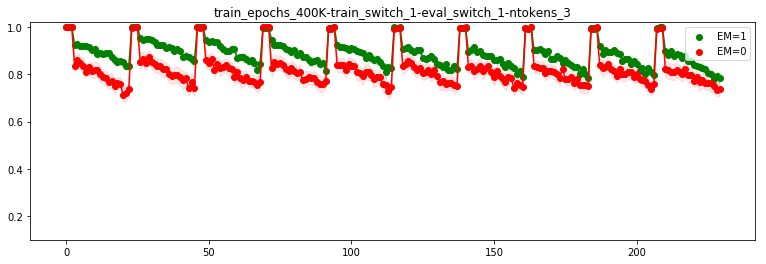

In [34]:
# params
neps = 50
ntrials = 10
seqlen = 20
ntokens = 3
    
for treps in [1,2,3,4]:
  for tr_switch in [0,1]:
    # load netL
    netL_EM1 = load_netL(1,treps,tr_switch,ntokens)
    netL_EM0 = load_netL(0,treps,tr_switch,ntokens)
    # task
    task = PurePM(ntokens=ntokens,stimdim=10,seed=np.random.randint(999)) 
    for ev_switch in [0,1]:
      # fig
      plt.close('all')
      plt.figure(figsize=(13,4))
      cL = ['g','r']
      labL = ['EM=1','EM=0']
      ax = plt.gca()
      ax.set_ylim(0.1,1.02)
      # eval, process and plot
      for idx,netL in enumerate([netL_EM1,netL_EM0]):
        acc = eval_netL(netL,task,neps,ntrials,seqlen,ev_switch)
        M = acc.mean(0)
        S = acc.std(0) / np.sqrt(len(acc))
        T = len(M)
        ax.plot(M,c=cL[idx])
        ax.scatter(range(T),M,c=cL[idx],label=labL[idx])
        ax.fill_between(range(T),M-S,M+S,alpha=.1,color=cL[idx])
      # save
      plt.legend(loc=1)
      fname = "train_epochs_%i00K-train_switch_%i-eval_switch_%i-ntokens_%i"%(
        treps,tr_switch,ev_switch,ntokens)
      plt.title(fname)
      plt.savefig('figures/EMconjcode/'+fname)

### model: percept LSTM layer

In [159]:
# init task
task = PurePM(
        ntokens=3,
        stimdim=10,
        seed=np.random.randint(999)
)

# list of networks
trep = 6
switch_train = 0
# with and without EM
netL_em0 = load_netL(0,trep,switch_train)
netL_em1 = load_netL(1,trep,switch_train)

N = 20 loaded nets
N = 20 loaded nets


In [162]:
neps = 500
ntrials = 5
seqlen = 5
switch_eval = 1

acc_em0 = eval_netL(netL_em0,task,neps,ntrials,seqlen,switch_eval)
acc_em1 = eval_netL(netL_em1,task,neps,ntrials,seqlen,switch_eval)

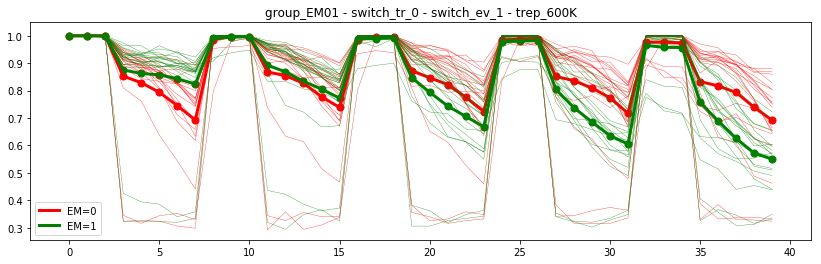

In [164]:
plt.figure(figsize=(14,4))
ax = plt.gca()
cL = ['r','g']
labL = ['EM=0','EM=1']

for gidx,acc in enumerate([acc_em0,acc_em1]):
  for sub_acc in acc:
    ax.plot(sub_acc,lw=.3,c=cL[gidx])
  ax.plot(acc.mean(0),c=cL[gidx],lw=3,label=labL[gidx])
  ax.scatter(range(acc.shape[1]),acc.mean(0),c=cL[gidx],s=50)
  
plt.legend()
title = "group_EM01-switch_tr_%i-switch_ev_%i-trep_%s00K"%(switch_train,switch_eval,trep)
plt.title(' - '.join(title.split('-')))
plt.savefig('figures/PIsweep_EM/'+title)

# debug

# Cluster script